In [1]:
#Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [101]:
# Path to the data
train_dir ='Dataset/seg_train/seg_train'
test_dir ='Dataset/seg_test/seg_test'

In [3]:
batch_size = 32  # Number of samples per gradient update during training.
image_size = (150, 150)  # Desired dimensions for image resizing.
epoch = 30  # Number of times the model will iterate over the entire training dataset.

# Data Augumentation

- We will use the ImageDataGenerator module of tensorflow to create augmented images. This module helps us with augmenting images based on the parameters set by us and it does not create multiple copies of augmented iamges (saves storage) instead it augments the images and sends it to the model on the go without saving it.

In [102]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

# Data augmentation and preprocessing for training images
train_datagen = ImageDataGenerator(rescale=1/255.,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='sparse')


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Data Visualization

In [5]:
# Generating a list of class labels based on the class indices from the train_generator
labels = [k for k in train_generator.class_indices]
labels

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

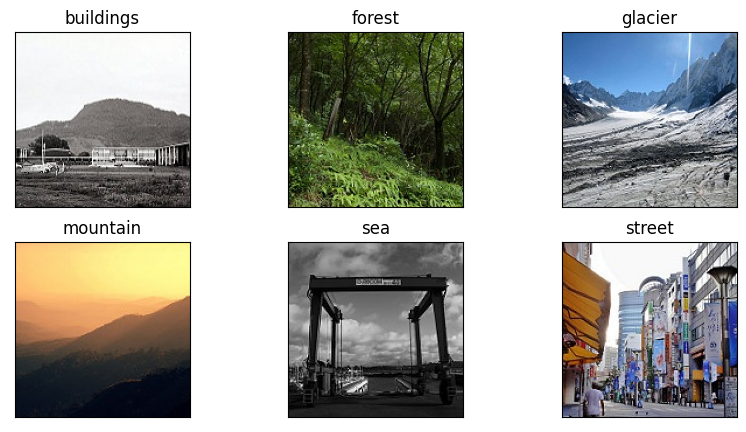

In [6]:
fig = plt.figure(figsize=(10, 5))

# Iterate through each label and display an image for each category
for i in range(len(labels)):
    ax = fig.add_subplot(2, 3, 1+i, xticks=[], yticks=[])
    
    # Construct the directory path for the current class
    class_dir = os.path.join(train_dir, labels[i])
    
    # Get the list of image filenames in the class directory
    img_filenames = os.listdir(class_dir)
    
    # Construct the path of the first image in the class
    img_path = os.path.join(class_dir, img_filenames[0])
    
    # Load and display the image
    im = plt.imread(img_path)
    ax.set_title(labels[i])
    plt.imshow(im)

plt.show()


### Creating early stopping and learning rate Scheduler

In [7]:
# Create early stopping callback
es=EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# Create learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, monitor='loss', verbose=1, min_lr = 0.000001)

### Creating Function for model visualization and model prediction

In [8]:
def visualize_model_performance(hist):
    # Convert training history to a DataFrame
    df = pd.DataFrame(hist.history)
    df['epochs'] = hist.epoch

     # Plot training and validation loss
    plt.plot(df['loss'], label='Training loss')
    plt.plot(df['val_loss'], label='Validation loss')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    

In [9]:
def analyze_model_predictions(model, test_generator, labels):
    # Get predictions for the test dataset
    predictions = model.predict(test_generator)
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Print classification report
    print('Classification Report:\n', classification_report(test_generator.classes, predicted_classes))
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(test_generator.classes, predicted_classes), annot=True, fmt='.3g', xticklabels=labels, yticklabels=labels)
    plt.show()

#  Model Architecture

### Model with SGD

In [10]:
# Create a Sequential model
model_sgd = Sequential()

# Add a Conv2D layer with 32 filters and a 3x3 kernel size
model_sgd.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
# Add a MaxPooling2D layer
model_sgd.add(MaxPooling2D())

# Add another Conv2D layer with 64 filters and a 3x3 kernel size, using ReLU activation
model_sgd.add(Conv2D(64, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model_sgd.add(MaxPooling2D())

# Add another Conv2D layer with 128 filters and a 3x3 kernel size, using ReLU activation
model_sgd.add(Conv2D(128, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model_sgd.add(MaxPooling2D())

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model_sgd.add(Conv2D(256, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model_sgd.add(MaxPooling2D())

# Flatten the output of the previous layers
model_sgd.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation, followed by dropout
model_sgd.add(Dense(512, activation='relu'))
model_sgd.add(Dropout(0.5))

# Add another Dense layer with 128 units and ReLU activation, followed by dropout
model_sgd.add(Dense(128, activation='relu'))
model_sgd.add(Dropout(0.5))

# Add the final Dense layer with 6 classes and softmax activation
model_sgd.add(Dense(6, activation='softmax'))

# Create an instance of SGD optimizer
opt = SGD()

# Compile the model with specified loss and metrics
model_sgd.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_sgd.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [11]:
# Define the filename for saving the model's weights
filename = 'Models/Sgdmodel.hdf5'

# Create a ModelCheckpoint callback
chkpt=ModelCheckpoint(filename, verbose=1, save_best_only =True)

tensorboard_callback = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=True, write_images=True)


In [12]:
#train the network
hist_sgd =model_sgd.fit(train_generator, validation_data=test_generator, 
                        epochs=epoch,callbacks=[chkpt, es, lr_scheduler, tensorboard_callback], verbose=1)

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.6056 - accuracy: 0.3230
Epoch 1: val_loss improved from inf to 1.41187, saving model to Models\Sgdmodel.hdf5
439/439 [==============================] - 226s 495ms/step - loss: 1.6056 - accuracy: 0.3230 - val_loss: 1.4119 - val_accuracy: 0.4337 - lr: 0.0100
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.3352 - accuracy: 0.4587
Epoch 2: val_loss improved from 1.41187 to 1.09308, saving model to Models\Sgdmodel.hdf5
439/439 [==============================] - 39s 89ms/step - loss: 1.3352 - accuracy: 0.4587 - val_loss: 1.0931 - val_accuracy: 0.5810 - lr: 0.0100
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.2192 - accuracy: 0.5076
Epoch 3: val_loss improved from 1.09308 to 1.05758, saving model to Models\Sgdmodel.hdf5
439/439 [==============================] - 38s 87ms/step - loss: 1.2192 - accuracy: 0.5076 - val_loss: 1.0576 - val_accuracy: 0.5793 - lr: 0.0100
Epoch 4/3

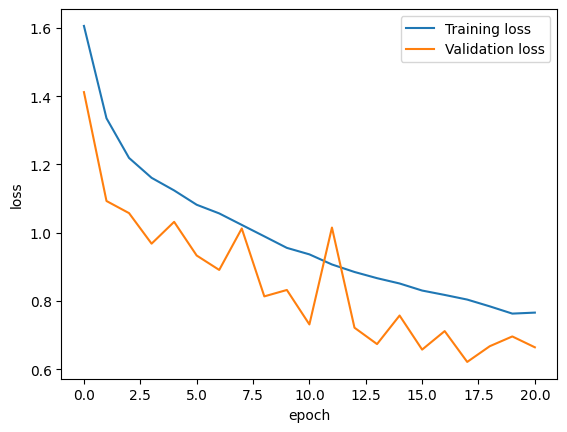

In [13]:
# Visualize the training and validation loss
visualize_model_performance(hist_sgd)

In [14]:
# Evaluate the model's performance on the test data
model_sgd.evaluate(test_generator)

94/94 [==============================] - 1s 15ms/step - loss: 0.6648 - accuracy: 0.7583


[0.6647753119468689, 0.7583333253860474]

94/94 [==============================] - 1s 15ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68       437
           1       0.89      0.95      0.92       474
           2       0.71      0.79      0.75       553
           3       0.74      0.76      0.75       525
           4       0.90      0.48      0.62       510
           5       0.70      0.89      0.79       501

    accuracy                           0.76      3000
   macro avg       0.77      0.76      0.75      3000
weighted avg       0.77      0.76      0.75      3000



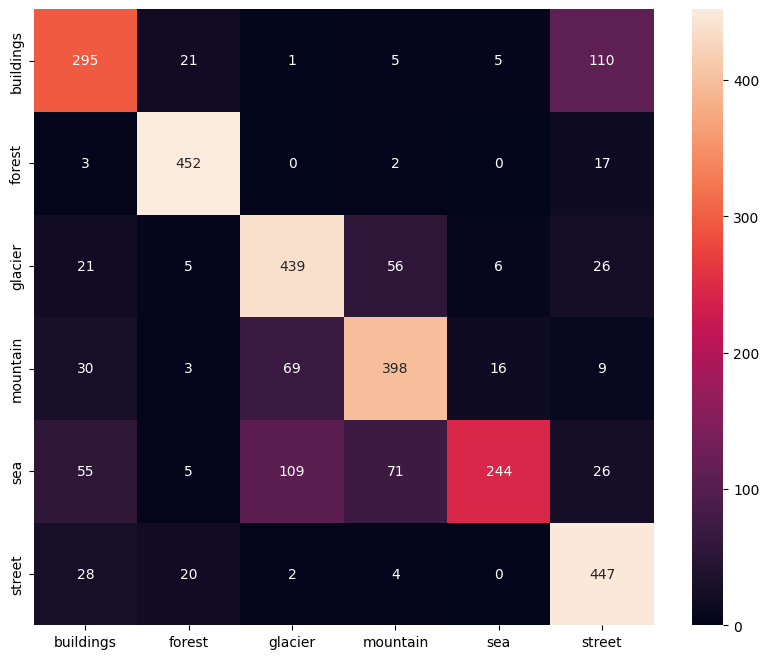

In [15]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(model_sgd, test_generator, labels)

- The stochastic gradient descents give an accuracy of 76%, Reacall of 76% and Precision of 77%

# Model with RMSprop

In [16]:
# Create a Sequential model
model = Sequential()

# Add a Conv2D layer with 32 filters and a 3x3 kernel size
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
# Add a MaxPooling2D layer
model.add(MaxPooling2D())

# Add another Conv2D layer with 64 filters and a 3x3 kernel size, using ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model.add(MaxPooling2D())

# Add another Conv2D layer with 128 filters and a 3x3 kernel size, using ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model.add(MaxPooling2D())

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model.add(Conv2D(256, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model.add(MaxPooling2D())

# Flatten the output of the previous layers
model.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation, followed by dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Add another Dense layer with 128 units and ReLU activation, followed by dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the final Dense layer with 6 units (equal to the number of classes) and softmax activation
model.add(Dense(6, activation='softmax'))

# Create an instance of RMSprop optimizer
opt = RMSprop()

# Compile the model with specified loss and metrics
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [17]:
filename='Models/RMSpropmodel.hdf5'
chkpt=ModelCheckpoint(filename, verbose=1, save_best_only =True)

In [18]:
#train the network
hist =model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.3821 - accuracy: 0.4423
Epoch 1: val_loss improved from inf to 1.16832, saving model to Models\RMSpropmodel.hdf5
439/439 [==============================] - 117s 265ms/step - loss: 1.3821 - accuracy: 0.4423 - val_loss: 1.1683 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 0.6165
Epoch 2: val_loss improved from 1.16832 to 0.76201, saving model to Models\RMSpropmodel.hdf5
439/439 [==============================] - 37s 84ms/step - loss: 1.0454 - accuracy: 0.6165 - val_loss: 0.7620 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.9268 - accuracy: 0.6721
Epoch 3: val_loss did not improve from 0.76201
439/439 [==============================] - 37s 85ms/step - loss: 0.9268 - accuracy: 0.6721 - val_loss: 0.8620 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 4/30
439/439 [=======================

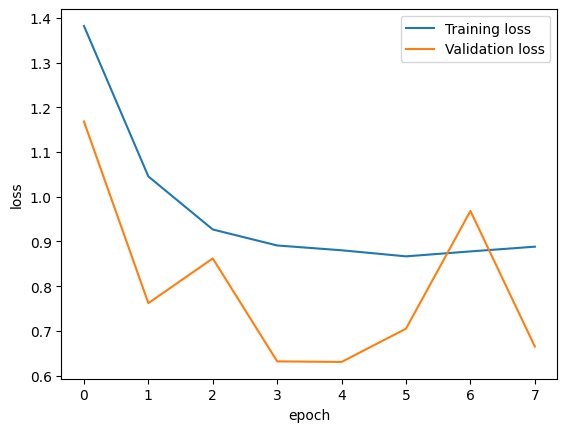

In [19]:
# Analyze and visualize the model's predictions on the test dataset
visualize_model_performance(hist)

In [20]:
model.evaluate(test_generator)

94/94 [==============================] - 2s 16ms/step - loss: 0.6648 - accuracy: 0.7897


[0.6648374199867249, 0.7896666526794434]

94/94 [==============================] - 2s 17ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.76       437
           1       0.98      0.88      0.93       474
           2       0.70      0.86      0.77       553
           3       0.86      0.64      0.73       525
           4       0.80      0.68      0.74       510
           5       0.70      0.95      0.81       501

    accuracy                           0.79      3000
   macro avg       0.81      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000



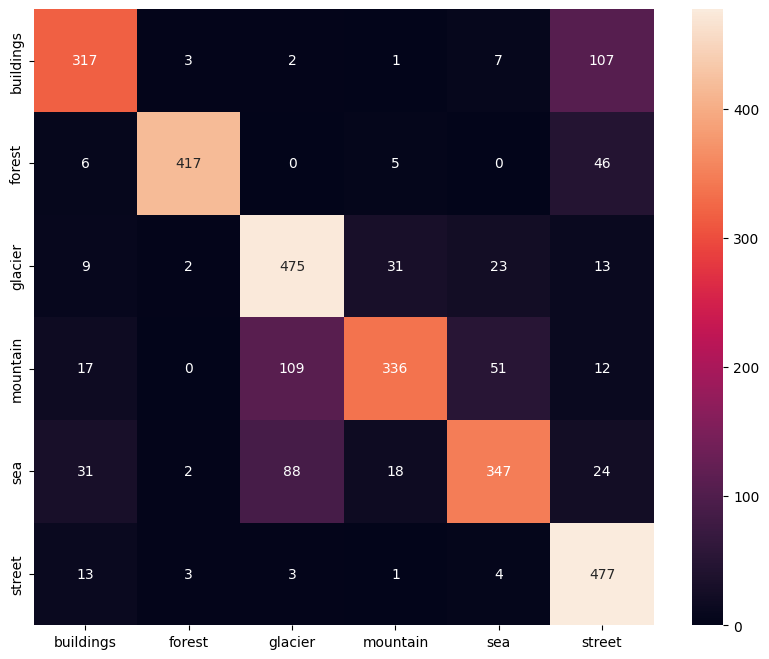

In [21]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(model, test_generator, labels)

- The RMSprop give an accuracy of 79%, Reacall of 79% and Precision of 81%

# Using Adam

### Model 1

In [22]:
# Create a Sequential model
model1 = Sequential()

# Add a Conv2D layer with 32 filters and a 3x3 kernel size
model1.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
# Add a MaxPooling2D layer
model1.add(MaxPooling2D())

# Add another Conv2D layer with 64 filters and a 3x3 kernel size, using ReLU activation
model1.add(Conv2D(64, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model1.add(MaxPooling2D())

# Add another Conv2D layer with 128 filters and a 3x3 kernel size, using ReLU activation
model1.add(Conv2D(128, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model1.add(MaxPooling2D())

# Add another Conv2D layer with 256 filters and a 3x3 kernel size, using ReLU activation
model1.add(Conv2D(256, (3, 3), activation='relu'))
# Add another MaxPooling2D layer
model1.add(MaxPooling2D())

# Flatten the output of the previous layers
model1.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation, followed by dropout
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))

# Add another Dense layer with 128 units and ReLU activation, followed by dropout
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

# Add the final Dense layer with 6 units (equal to the number of classes) and softmax activation
model1.add(Dense(6, activation='softmax'))

# Compile the model with Adam optimizer and specified loss and metrics
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [23]:
filename1='Models/Adammodel.hdf5'

chkpt=ModelCheckpoint(filename1, verbose=1, save_best_only =True)

In [24]:
#train the network
hist1 =model1.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.4608
Epoch 1: val_loss improved from inf to 0.94494, saving model to Models\Adammodel.hdf5
439/439 [==============================] - 38s 85ms/step - loss: 1.3028 - accuracy: 0.4608 - val_loss: 0.9449 - val_accuracy: 0.6110 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.0213 - accuracy: 0.6013
Epoch 2: val_loss improved from 0.94494 to 0.86616, saving model to Models\Adammodel.hdf5
439/439 [==============================] - 37s 84ms/step - loss: 1.0213 - accuracy: 0.6013 - val_loss: 0.8662 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.9151 - accuracy: 0.6631
Epoch 3: val_loss improved from 0.86616 to 0.70293, saving model to Models\Adammodel.hdf5
439/439 [==============================] - 37s 84ms/step - loss: 0.9151 - accuracy: 0.6631 - val_loss: 0.7029 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 4/

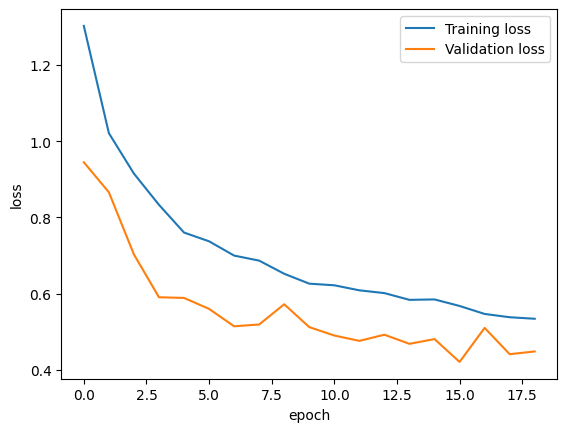

In [25]:
# Visualize the training and validation loss
visualize_model_performance(hist1)

In [26]:
# Evaluate the model's performance on the test data
model1.evaluate(test_generator)

94/94 [==============================] - 1s 14ms/step - loss: 0.4483 - accuracy: 0.8323


[0.4482939541339874, 0.8323333263397217]

94/94 [==============================] - 1s 13ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81       437
           1       0.98      0.94      0.96       474
           2       0.74      0.86      0.80       553
           3       0.85      0.73      0.78       525
           4       0.90      0.75      0.82       510
           5       0.91      0.78      0.84       501

    accuracy                           0.83      3000
   macro avg       0.85      0.84      0.83      3000
weighted avg       0.85      0.83      0.83      3000



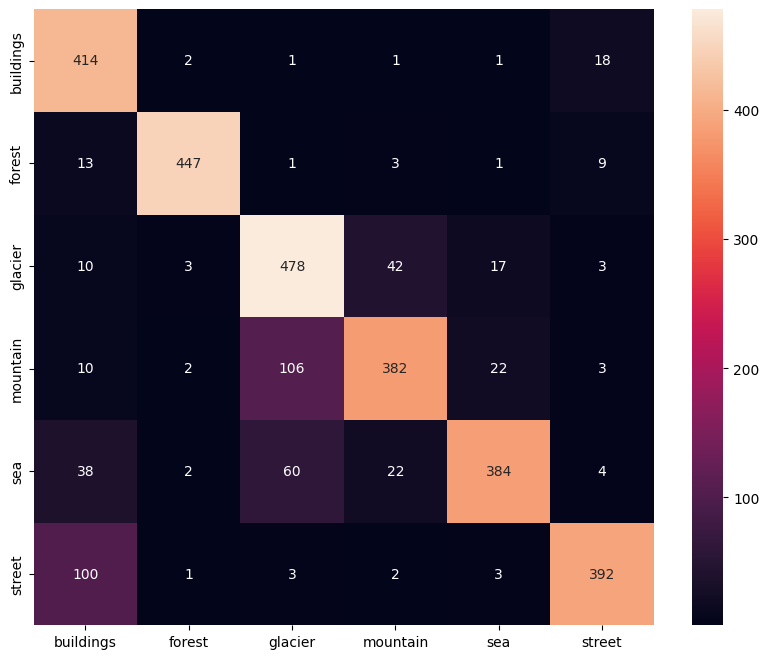

In [27]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(model1, test_generator, labels)

- The Adam optimizer with the base learning rate give an accuracy of 83%, Reacall of 84% and Precision of 85%

# Model 2

In [28]:
# Create a Sequential model
model2 = Sequential()

# Add a Conv2D layer with 32 filters, a 3x3 kernel size, and 'same' padding
model2.add(Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)))
# Add a MaxPooling2D layer
model2.add(MaxPooling2D())

# Add another Conv2D layer with 64 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model2.add(MaxPooling2D())

# Add another Conv2D layer with 128 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model2.add(MaxPooling2D())

# Add another Conv2D layer with 256 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model2.add(MaxPooling2D())

# Flatten the output of the previous layers
model2.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation, followed by dropout
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))

# Add another Dense layer with 128 units and ReLU activation, followed by dropout
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

# Add the final Dense layer with 6 units (equal to the number of classes) and softmax activation
model2.add(Dense(6, activation='softmax'))

# Create an instance of Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.0001)

# Compile the model with Adam optimizer and specified loss and metrics
model2.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 128)     

In [29]:
filename2='Models/Basemodel2.hdf5'

chkpt=ModelCheckpoint(filename2, verbose=1, save_best_only =True)

In [30]:
#train the network
hist2 =model2.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.3213 - accuracy: 0.4637
Epoch 1: val_loss improved from inf to 1.01394, saving model to Models\Basemodel2.hdf5
439/439 [==============================] - 39s 86ms/step - loss: 1.3213 - accuracy: 0.4637 - val_loss: 1.0139 - val_accuracy: 0.6007 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.0910 - accuracy: 0.5844
Epoch 2: val_loss improved from 1.01394 to 0.86022, saving model to Models\Basemodel2.hdf5
439/439 [==============================] - 38s 86ms/step - loss: 1.0910 - accuracy: 0.5844 - val_loss: 0.8602 - val_accuracy: 0.6880 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.9635 - accuracy: 0.6422
Epoch 3: val_loss improved from 0.86022 to 0.77309, saving model to Models\Basemodel2.hdf5
439/439 [==============================] - 38s 86ms/step - loss: 0.9635 - accuracy: 0.6422 - val_loss: 0.7731 - val_accuracy: 0.7150 - lr: 1.00

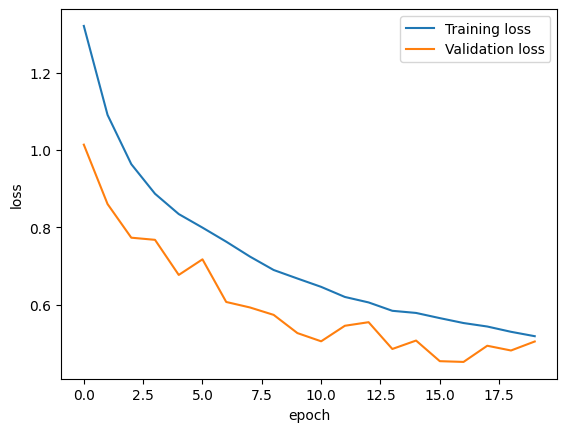

In [31]:
# Visualize the training and validation loss
visualize_model_performance(hist2)

In [32]:
# Evaluate the model's performance on the test data
model2.evaluate(test_generator)

94/94 [==============================] - 1s 14ms/step - loss: 0.5044 - accuracy: 0.8240


[0.5043919086456299, 0.8240000009536743]

94/94 [==============================] - 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       437
           1       0.80      0.99      0.88       474
           2       0.88      0.71      0.78       553
           3       0.78      0.82      0.80       525
           4       0.84      0.86      0.85       510
           5       0.88      0.77      0.82       501

    accuracy                           0.82      3000
   macro avg       0.83      0.83      0.82      3000
weighted avg       0.83      0.82      0.82      3000



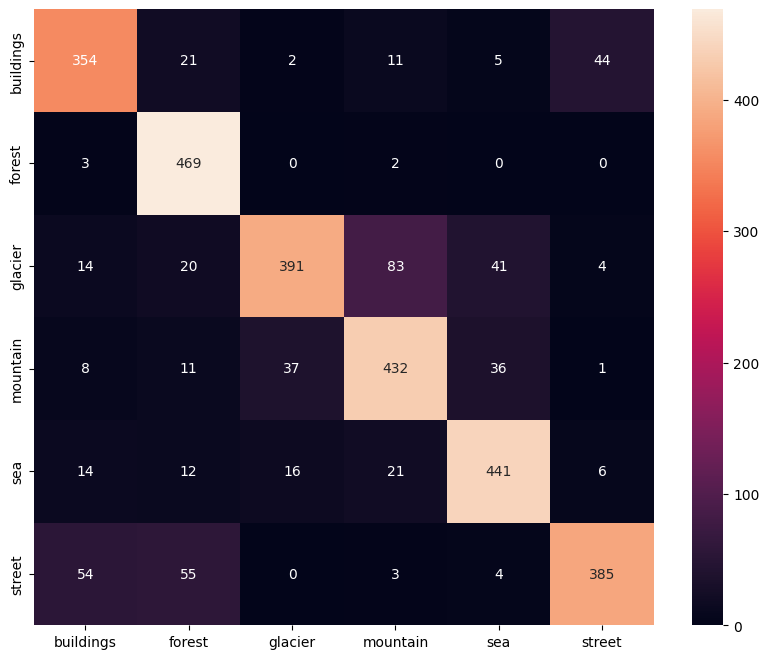

In [33]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(model2, test_generator, labels)

- The Adam optimizer with the learning rate of 0.0001 give an accuracy of 82%, Reacall of 83% and Precision of 83%

# Model 3

In [34]:
# Create a Sequential model
model3 = Sequential()

# Add a Conv2D layer with 32 filters, a 3x3 kernel size, and 'same' padding
model3.add(Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)))
# Add a MaxPooling2D layer
model3.add(MaxPooling2D())

# Add another Conv2D layer with 64 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model3.add(MaxPooling2D())

# Add another Conv2D layer with 128 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model3.add(MaxPooling2D())

# Add another Conv2D layer with 128 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model3.add(MaxPooling2D())

# Add another Conv2D layer with 256 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
model3.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# Add another MaxPooling2D layer
model3.add(MaxPooling2D())

# Flatten the output of the previous layers
model3.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation, followed by dropout
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))

# Add another Dense layer with 128 units and ReLU activation, followed by dropout
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

# Add the final Dense layer with 6 units (equal to the number of classes) and softmax activation
model3.add(Dense(6, activation='softmax'))

# Create an instance of Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.00001)

# Compile the model with Adam optimizer and specified loss and metrics
model3.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 18, 18, 128)     

In [35]:
filename3='Models/Basemodel3.hdf5'

chkpt=ModelCheckpoint(filename3, verbose=1, save_best_only =True)

In [37]:
#train the network
hist3 =model3.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.6673 - accuracy: 0.2940
Epoch 1: val_loss did not improve from 0.38825
439/439 [==============================] - 104s 235ms/step - loss: 1.6673 - accuracy: 0.2940 - val_loss: 1.4147 - val_accuracy: 0.4223 - lr: 1.0000e-05
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.3975 - accuracy: 0.4323
Epoch 2: val_loss did not improve from 0.38825
439/439 [==============================] - 50s 114ms/step - loss: 1.3975 - accuracy: 0.4323 - val_loss: 1.2603 - val_accuracy: 0.4973 - lr: 1.0000e-05
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.3159 - accuracy: 0.4736
Epoch 3: val_loss did not improve from 0.38825
439/439 [==============================] - 37s 84ms/step - loss: 1.3159 - accuracy: 0.4736 - val_loss: 1.1902 - val_accuracy: 0.5300 - lr: 1.0000e-05
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 1.2552 - accuracy: 0.5010
Epoch 4: val_loss did 

Epoch 28: early stopping


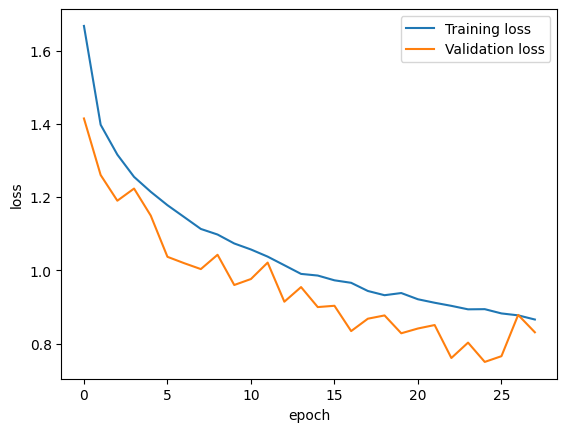

In [38]:
# Visualize the training and validation loss
visualize_model_performance(hist3)

In [39]:
# Evaluate the model's performance on the test data
model3.evaluate(test_generator)

94/94 [==============================] - 2s 16ms/step - loss: 0.8310 - accuracy: 0.7023


[0.8309571146965027, 0.7023333311080933]

94/94 [==============================] - 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.70      0.59       437
           1       0.81      0.96      0.88       474
           2       0.75      0.58      0.66       553
           3       0.69      0.68      0.69       525
           4       0.79      0.52      0.63       510
           5       0.71      0.80      0.75       501

    accuracy                           0.70      3000
   macro avg       0.71      0.71      0.70      3000
weighted avg       0.72      0.70      0.70      3000



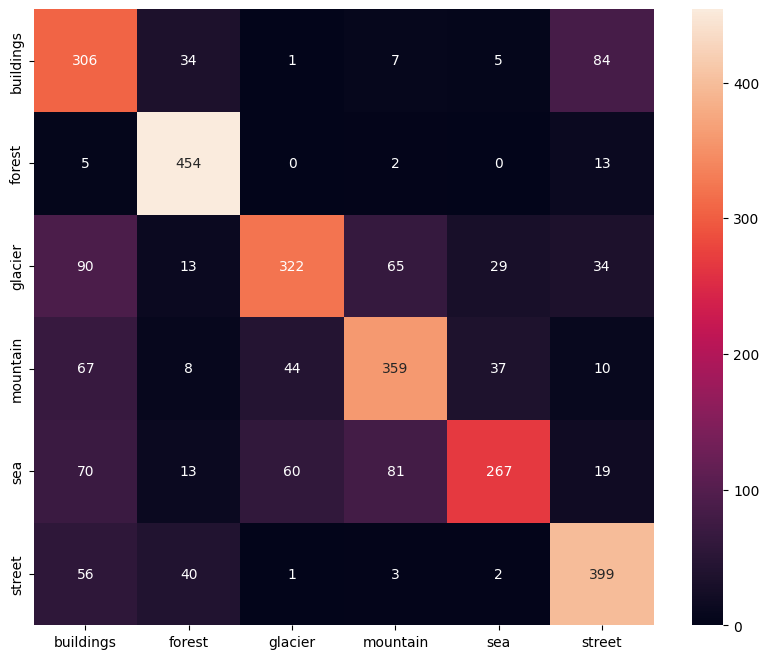

In [40]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(model3, test_generator, labels)

- The Adam optimizer with the learning rate of 0.00001 give an accuracy of 70%, Reacall of 71% and Precision of 71%

# VGG16

In [41]:
from keras.applications.vgg16 import VGG16

# Load the VGG16 model with pre-trained ImageNet weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Display the summary of the VGG16 model
vgg_model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [42]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [44]:
vgg16_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
vgg16_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
vgg16_model.add(GlobalAveragePooling2D())

# Adding a fully connected dense layer with 512 neurons  and Dropout of 0.5

vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(Dropout(0.5))

# Adding the output layer with 10 neurons and activation functions as softmax
vgg16_model.add(Dense(6, activation='softmax'))

adam=Adam(0.0001)

# Compile model
vgg16_model.compile(optimizer = adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
vgg16_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 14,980,422
Trainable params: 265,734
Non-trainable params: 14,714,688
____________________________________

In [45]:
filename4='Models/Vgg16model.hdf5'

chkpt=ModelCheckpoint(filename4, verbose=1, save_best_only =True)

In [46]:
#train the network
hist4 =vgg16_model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.2262 - accuracy: 0.5326
Epoch 1: val_loss improved from inf to 0.77295, saving model to Models\Vgg16model.hdf5
439/439 [==============================] - 44s 99ms/step - loss: 1.2262 - accuracy: 0.5326 - val_loss: 0.7730 - val_accuracy: 0.7757 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.7226
Epoch 2: val_loss improved from 0.77295 to 0.60918, saving model to Models\Vgg16model.hdf5
439/439 [==============================] - 38s 86ms/step - loss: 0.7701 - accuracy: 0.7226 - val_loss: 0.6092 - val_accuracy: 0.7953 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7500
Epoch 3: val_loss improved from 0.60918 to 0.54266, saving model to Models\Vgg16model.hdf5
439/439 [==============================] - 38s 86ms/step - loss: 0.6739 - accuracy: 0.7500 - val_loss: 0.5427 - val_accuracy: 0.8120 - lr: 1.00

439/439 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.8329
Epoch 26: val_loss did not improve from 0.38067
439/439 [==============================] - 38s 86ms/step - loss: 0.4593 - accuracy: 0.8329 - val_loss: 0.3849 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 27/30
439/439 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.8313
Epoch 27: val_loss did not improve from 0.38067

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
439/439 [==============================] - 37s 85ms/step - loss: 0.4582 - accuracy: 0.8313 - val_loss: 0.3891 - val_accuracy: 0.8523 - lr: 1.0000e-04
Epoch 28/30
439/439 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8288
Epoch 28: val_loss did not improve from 0.38067
439/439 [==============================] - 37s 85ms/step - loss: 0.4539 - accuracy: 0.8288 - val_loss: 0.3823 - val_accuracy: 0.8547 - lr: 2.0000e-05
Epoch 28: early stopping


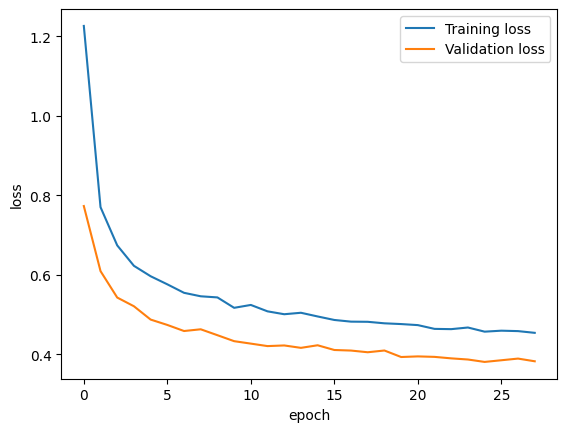

In [47]:
# Visualize the training and validation loss
visualize_model_performance(hist4)

In [48]:
# Evaluate the model's performance on the test data
vgg16_model.evaluate(test_generator)

94/94 [==============================] - 15s 162ms/step - loss: 0.3823 - accuracy: 0.8547


[0.3822862207889557, 0.8546666502952576]

94/94 [==============================] - 2s 23ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       437
           1       0.97      0.97      0.97       474
           2       0.75      0.85      0.80       553
           3       0.83      0.74      0.78       525
           4       0.86      0.82      0.84       510
           5       0.89      0.86      0.88       501

    accuracy                           0.85      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.85      0.85      3000



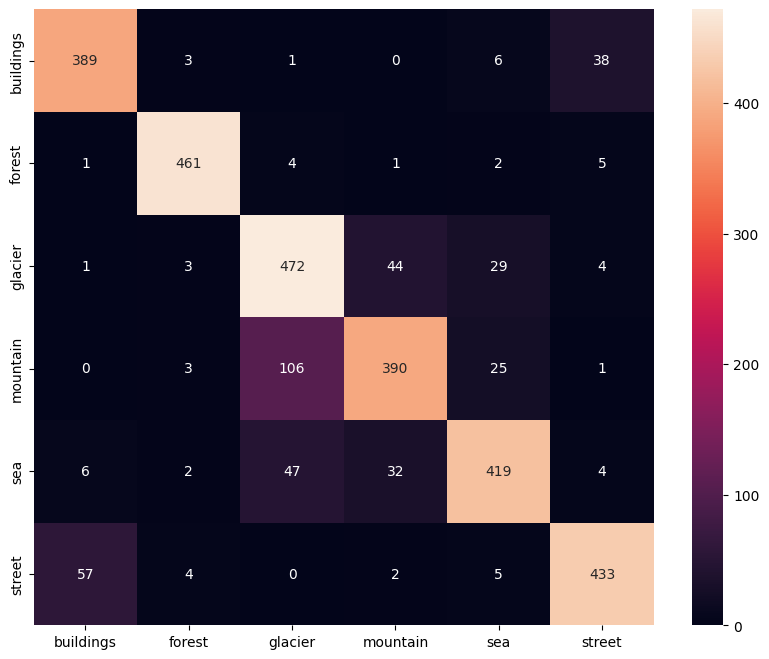

In [49]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(vgg16_model, test_generator, labels)

- The VGG16 pre-trained model with the learning rate of 0.0001 give an accuracy of 85%, Reacall of 86% and Precision of 86%

# ResNet50

In [50]:
from keras.applications import ResNet50

# Load the ResNet50 model with pre-trained ImageNet weights
Resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Display the summary of the ResNet50 model
Resnet_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
          

 conv5_block1_out (Activation)  (None, 5, 5, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

In [51]:
# Making all the layers of the Resnet model non-trainable. i.e. freezing them
for layer in Resnet_model.layers:
    layer.trainable = False

In [52]:
resnet50_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
resnet50_model.add(Resnet_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
resnet50_model.add(GlobalAveragePooling2D())

resnet50_model.add(Dense(512, activation='relu'))
resnet50_model.add(Dropout(0.5))

# Adding the output layer with 10 neurons and activation functions as softmax
resnet50_model.add(Dense(6, activation='softmax'))

adam=Adam(0.0001)

# Compile model
resnet50_model.compile(optimizer = adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
resnet50_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_17 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 24,639,878
Trainable params: 1,052,166
Non-trainable params: 23,587,712
__________________________________

In [53]:
filename5='Models/Resnetmodel.hdf5'

chkpt=ModelCheckpoint(filename5, verbose=1, save_best_only =True)

In [54]:
#train the network
Resnet50 =resnet50_model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.7637 - accuracy: 0.2339
Epoch 1: val_loss improved from inf to 1.62265, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 104s 232ms/step - loss: 1.7637 - accuracy: 0.2339 - val_loss: 1.6227 - val_accuracy: 0.3393 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.6177 - accuracy: 0.3271
Epoch 2: val_loss improved from 1.62265 to 1.53656, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 39s 88ms/step - loss: 1.6177 - accuracy: 0.3271 - val_loss: 1.5366 - val_accuracy: 0.3973 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.5509 - accuracy: 0.3526
Epoch 3: val_loss improved from 1.53656 to 1.45910, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 39s 88ms/step - loss: 1.5509 - accuracy: 0.3526 - val_loss: 1.4591 - val_accuracy: 0.4270 - lr:

439/439 [==============================] - 39s 88ms/step - loss: 1.1948 - accuracy: 0.5098 - val_loss: 1.0455 - val_accuracy: 0.5877 - lr: 1.0000e-04
Epoch 26/30
439/439 [==============================] - ETA: 0s - loss: 1.1961 - accuracy: 0.5060
Epoch 26: val_loss improved from 1.04550 to 1.04384, saving model to Models\Resnetmodel.hdf5
439/439 [==============================] - 38s 87ms/step - loss: 1.1961 - accuracy: 0.5060 - val_loss: 1.0438 - val_accuracy: 0.5663 - lr: 1.0000e-04
Epoch 27/30
439/439 [==============================] - ETA: 0s - loss: 1.1924 - accuracy: 0.5098
Epoch 27: val_loss did not improve from 1.04384
439/439 [==============================] - 38s 85ms/step - loss: 1.1924 - accuracy: 0.5098 - val_loss: 1.0467 - val_accuracy: 0.5920 - lr: 1.0000e-04
Epoch 28/30
439/439 [==============================] - ETA: 0s - loss: 1.1820 - accuracy: 0.5172
Epoch 28: val_loss did not improve from 1.04384
439/439 [==============================] - 38s 85ms/step - loss: 1.182

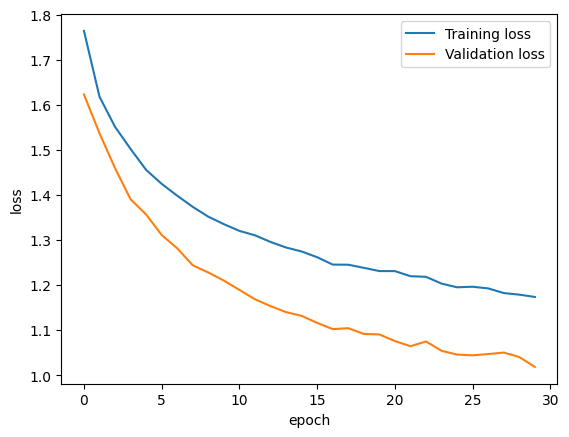

In [55]:
# Visualize the training and validation loss
visualize_model_performance(Resnet50)

In [56]:
# Evaluate the model's performance on the test data
resnet50_model.evaluate(test_generator)

94/94 [==============================] - 2s 21ms/step - loss: 1.0181 - accuracy: 0.5993


[1.0181280374526978, 0.5993333458900452]

94/94 [==============================] - 3s 23ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.58       437
           1       0.76      0.87      0.81       474
           2       0.49      0.58      0.53       553
           3       0.51      0.40      0.45       525
           4       0.60      0.54      0.57       510
           5       0.67      0.64      0.66       501

    accuracy                           0.60      3000
   macro avg       0.60      0.60      0.60      3000
weighted avg       0.60      0.60      0.60      3000



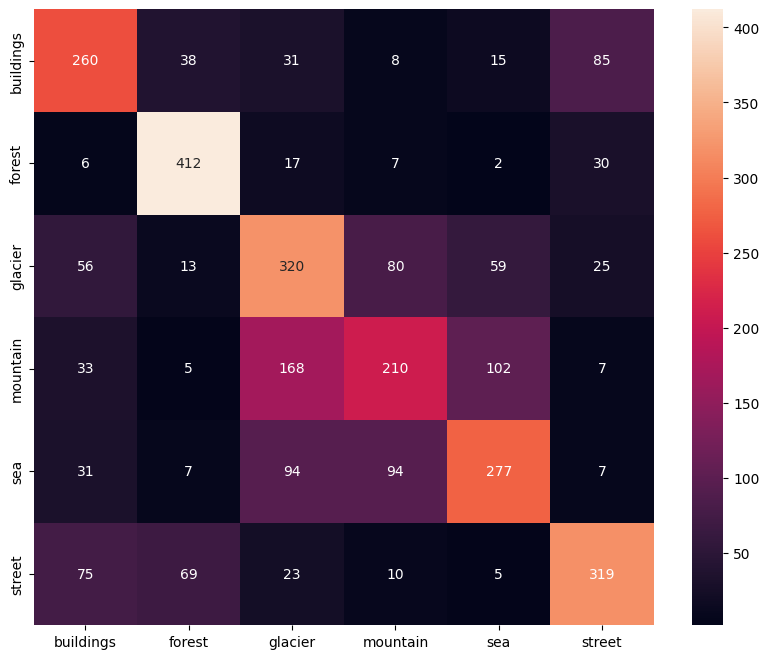

In [57]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(resnet50_model, test_generator, labels)

- The ResNet-50 pre-trained model with the learning rate of 0.0001 give an accuracy of 60%, Reacall of 60% and Precision of 60%

# Inception V3

In [58]:
from keras.applications import InceptionV3

# Load the InceptionV3 model with pre-trained ImageNet weights
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Display the summary of the InceptionV3 model
inception_model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_21[0][0]']              
 alization)                                                                                       
                      

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 64)  192         ['conv2d_28[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_41[0][0]']              
 ormalization)                                                                                    
          

 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_23[0][0]']       
                                                                                                  
 conv2d_55 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_65 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 7, 7, 160)   480         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_54 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_72

 batch_normalization_65 (BatchN  (None, 7, 7, 192)   576         ['conv2d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_87 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_82[0][0]']              
 ormalizat

 conv2d_91 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 7, 7, 192)   576         ['conv2d_91[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 batch_normalization_76 (BatchN  (None, 3, 3, 320)   960         ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 3, 3, 192)   576         ['conv2d_114[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [59]:
# Making all the layers of the inception model non-trainable. i.e. freezing them
for layer in inception_model.layers:
    layer.trainable = False

In [60]:
inceptionv3_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
inceptionv3_model.add(inception_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
inceptionv3_model.add(GlobalAveragePooling2D())


inceptionv3_model.add(Dense(512, activation='relu'))
inceptionv3_model.add(Dropout(0.5))

# Adding the output layer with 10 neurons and activation functions as softmax
inceptionv3_model.add(Dense(6, activation='softmax'))

adam=Adam(0.0001)

# Compile model
inceptionv3_model.compile(optimizer = adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
inceptionv3_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 22,854,950
Trainable params: 1,052,166
Non-trainable params: 21,802,784
__________________________________

In [61]:
filename6='Models/inceptionmodel.hdf5'

chkpt=ModelCheckpoint(filename6, verbose=1, save_best_only =True)


In [62]:
#train the network
inception =inceptionv3_model.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.7290
Epoch 1: val_loss improved from inf to 0.41635, saving model to Models\inceptionmodel.hdf5
439/439 [==============================] - 42s 91ms/step - loss: 0.7782 - accuracy: 0.7290 - val_loss: 0.4164 - val_accuracy: 0.8597 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.8132
Epoch 2: val_loss improved from 0.41635 to 0.36790, saving model to Models\inceptionmodel.hdf5
439/439 [==============================] - 39s 89ms/step - loss: 0.5293 - accuracy: 0.8132 - val_loss: 0.3679 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.8259
Epoch 3: val_loss improved from 0.36790 to 0.34749, saving model to Models\inceptionmodel.hdf5
439/439 [==============================] - 39s 88ms/step - loss: 0.4801 - accuracy: 0.8259 - val_loss: 0.3475 - val_accuracy: 0.871

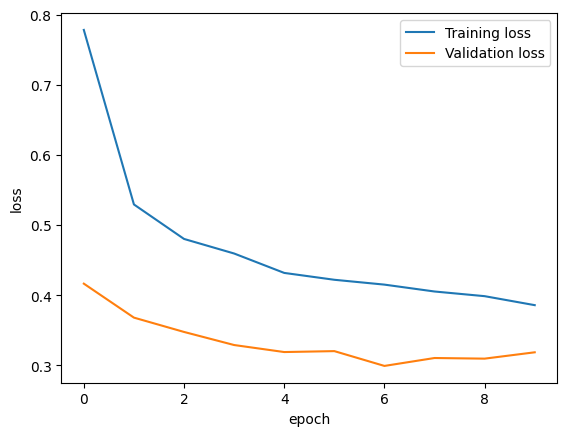

In [63]:
# Visualize the training and validation loss
visualize_model_performance(inception)

In [64]:
# Evaluate the model's performance on the test data
inceptionv3_model.evaluate(test_generator)

94/94 [==============================] - 2s 21ms/step - loss: 0.3185 - accuracy: 0.8807


[0.31845447421073914, 0.8806666731834412]

94/94 [==============================] - 2s 17ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.96      0.88       437
           1       0.99      0.98      0.98       474
           2       0.89      0.73      0.80       553
           3       0.78      0.89      0.83       525
           4       0.90      0.96      0.93       510
           5       0.96      0.80      0.87       501

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.88      3000
weighted avg       0.89      0.88      0.88      3000



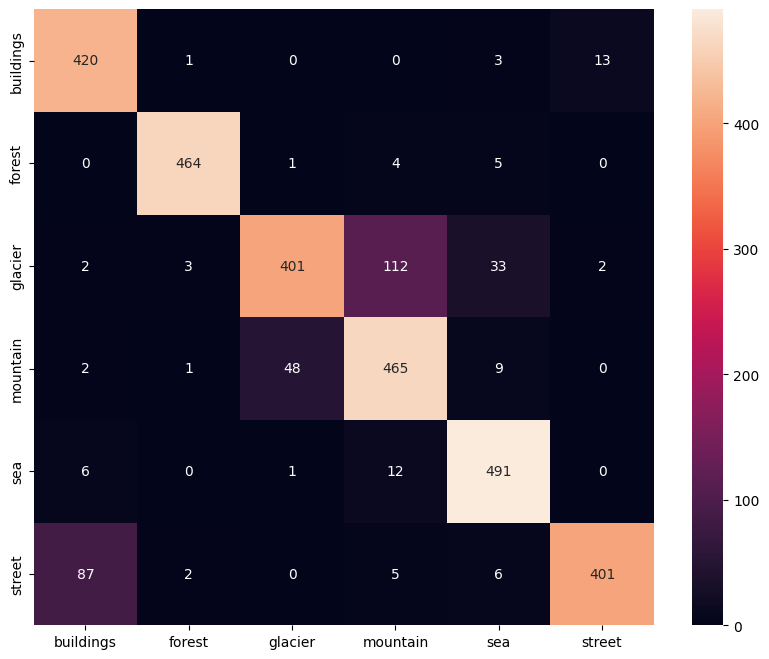

In [65]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(inceptionv3_model, test_generator, labels)

- The Inception v3 pre-trained model with the learning rate of 0.0001 give an accuracy of 88%, Reacall of 89% and Precision of 89%

### Hyper-parameter Tuning Using learning rate of 0.001

In [77]:
from keras.applications import InceptionV3

# Load the InceptionV3 model with pre-trained ImageNet weights
inception_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Display the summary of the InceptionV3 model
inception_model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_209 (Conv2D)            (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_209[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 16, 16, 96)  288         ['conv2d_219[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 16, 16, 32)  96          ['conv2d_220[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_193 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_193[0][0]']
                                                                                                  
 activatio

 activation_210 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_229 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_232 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_normalization_208 (Batch  (None, 16, 16, 48)  144         ['conv2d_229[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_211 (Batch  (None, 16, 16, 96)  288         ['conv2d_232[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_31[0][0]']       
                                                                                                  
 conv2d_243 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_222 (Batch  (None, 7, 7, 128)   384         ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_222 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_222[0][0]']
          

                                                                                                  
 batch_normalization_232 (Batch  (None, 7, 7, 160)   480         ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_232[0][0]']
                                                                                                  
 conv2d_254 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_232[0][0]']         
                                                                                                  
 batch_normalization_233 (Batch  (None, 7, 7, 160)   480         ['conv2d_254[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_264 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 7, 7, 160)   480         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_243 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_243[0][0]']
                                                                                                  
 conv2d_260 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_26

                                                                                                  
 activation_253 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_270 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_275 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_253[0][0]']         
                                                                                                  
 batch_normalization_249 (Batch  (None, 7, 7, 192)   576         ['conv2d_270[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_283 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 7, 7, 192)   576         ['conv2d_279[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_262 (Batch  (None, 7, 7, 192)   576         ['conv2d_283[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_258 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_258[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_266 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_267[0][0]']
                                                                                                  
 activation_270 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_270[0][0]']
                                                                                                  
 activation_271 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_271[0][0]']
                                                                                                  
 batch_normalization_272 (Batch  (None, 3, 3, 192)   576         ['conv2d_293[0][0]']             
 Normaliza

                                                                                                  
 activation_280 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 3, 3, 192)   576         ['conv2d_302[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_273 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_273[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_275[0][0]',         
                                                                  'activation_276[0][0]']         
          

In [78]:
# Making all the layers of the inception model non-trainable. i.e. freezing them
for layer in inception_model2.layers:
    layer.trainable = False

In [79]:
inceptionv3_model2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
inceptionv3_model2.add(inception_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
inceptionv3_model2.add(GlobalAveragePooling2D())


inceptionv3_model2.add(Dense(512, activation='relu'))
inceptionv3_model2.add(Dropout(0.5))

# Adding the output layer with 10 neurons and activation functions as softmax
inceptionv3_model2.add(Dense(6, activation='softmax'))

adam=Adam(0.001)

# Compile model
inceptionv3_model2.compile(optimizer = adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
inceptionv3_model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_23 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 22,854,950
Trainable params: 1,052,166
Non-trainable params: 21,802,784
_________________________________

In [80]:
filename7='Models/inceptionmodel2.hdf5'

chkpt=ModelCheckpoint(filename7, verbose=1, save_best_only =True)

In [81]:
#train the network
inception2 =inceptionv3_model2.fit(train_generator, validation_data=test_generator, epochs=epoch,callbacks=[chkpt, es, lr_scheduler], verbose=1 )

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7668
Epoch 1: val_loss improved from inf to 0.35924, saving model to Models\inceptionmodel2.hdf5
439/439 [==============================] - 148s 332ms/step - loss: 0.6836 - accuracy: 0.7668 - val_loss: 0.3592 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.8122
Epoch 2: val_loss improved from 0.35924 to 0.33826, saving model to Models\inceptionmodel2.hdf5
439/439 [==============================] - 40s 90ms/step - loss: 0.5159 - accuracy: 0.8122 - val_loss: 0.3383 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8206
Epoch 3: val_loss improved from 0.33826 to 0.32274, saving model to Models\inceptionmodel2.hdf5
439/439 [==============================] - 204s 466ms/step - loss: 0.4883 - accuracy: 0.8206 - val_loss: 0.3227 - val_accuracy: 0.8780

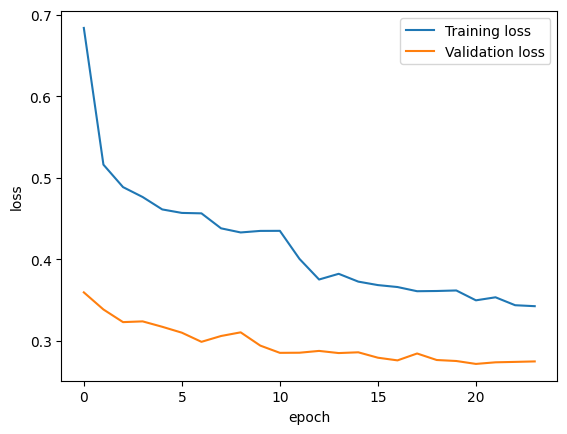

In [83]:
# Visualize the training and validation loss
visualize_model_performance(inception2)

In [84]:
# Evaluate the model's performance on the test data
inceptionv3_model2.evaluate(test_generator)

94/94 [==============================] - 2s 18ms/step - loss: 0.2745 - accuracy: 0.8933


[0.2745421826839447, 0.8933333158493042]

94/94 [==============================] - 2s 15ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       437
           1       0.99      0.97      0.98       474
           2       0.86      0.79      0.82       553
           3       0.80      0.86      0.83       525
           4       0.91      0.95      0.93       510
           5       0.94      0.88      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000



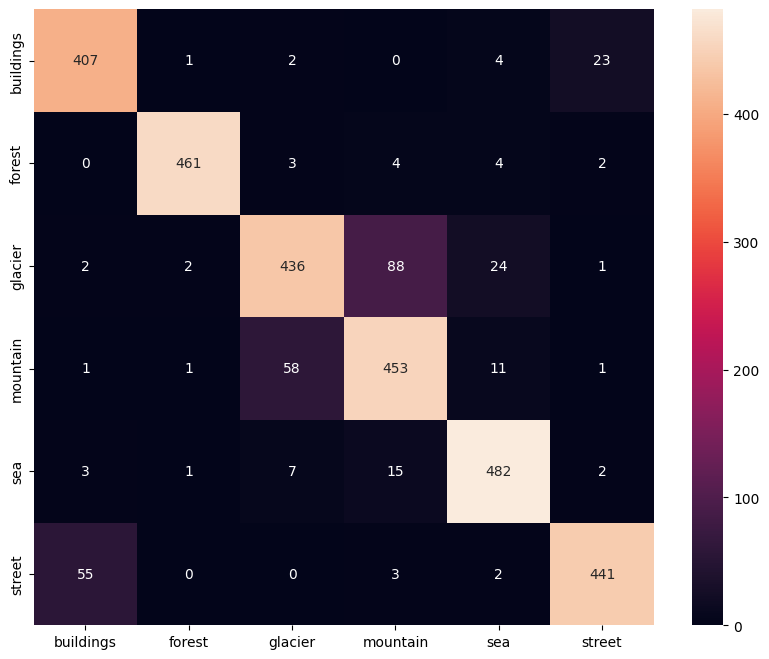

In [85]:
# Analyze and visualize the model's predictions on the test dataset
analyze_model_predictions(inceptionv3_model2, test_generator, labels)

- The Inception v3 pre-trained model with the learning rate of 0.001 give an accuracy of 89%, Reacall of 90% and Precision of 90%